In [73]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

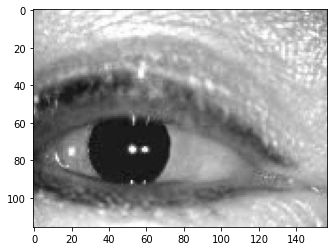

In [74]:
img = cv2.imread('pupil8.PNG',1)
newImage = img.copy()
newImage1 = img.copy()
newImage2 = img.copy()
newImage3 = img.copy()
plt.imshow(img)

Text(0.5, 1.0, 'Morph3')

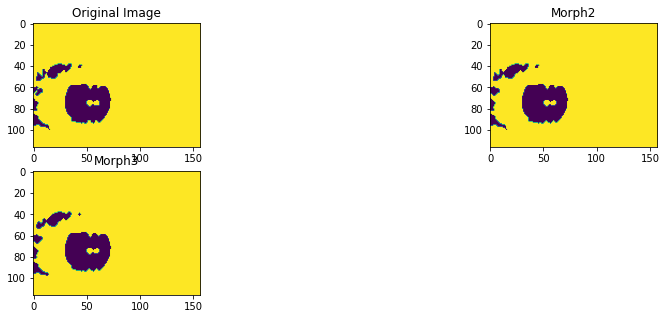

In [75]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(image_gray,(3,3),0)
ret,thresh1 = cv2.threshold(blur,60,255,cv2.THRESH_BINARY)
opening = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

fig = plt.figure(figsize=(15, 5))
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(thresh1)
plt.axis('on')
plt.title("Original Image")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(opening)
plt.axis('on')
plt.title("Morph2")

fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(closing)
plt.axis('on')
plt.title("Morph3")

Text(0.5, 1.0, 'Convex Correction')

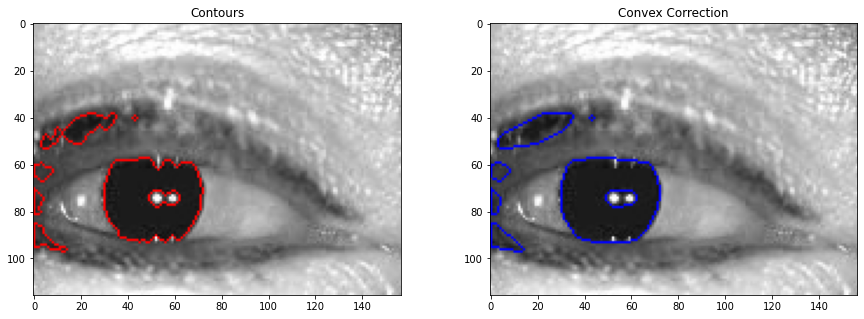

In [76]:
image = 255 - closing
_,contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
hull = []
for i in range(len(contours)):
    hull.append(cv2.convexHull(contours[i], False))
fig = plt.figure(figsize=(15, 5))
rows = 1
columns = 2    

fig.add_subplot(rows, columns, 1)
  
# showing image
cv2.drawContours(img, contours,-1, (255, 0, 0),1)
plt.imshow(img)
plt.axis('on')
plt.title("Contours")

fig.add_subplot(rows, columns, 2)
cv2.drawContours(newImage, hull,-1, (0, 0, 255),1)
plt.imshow(newImage)
plt.axis('on')
plt.title("Convex Correction")


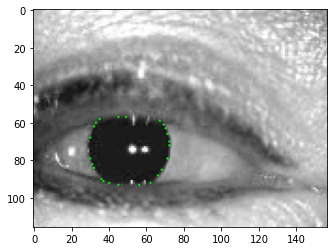

In [77]:
cnt = sorted(hull, key=cv2.contourArea)
maxcnt = cnt[-1]
cv2.drawContours(newImage1,maxcnt,-1, (0, 255, 0),1)
plt.imshow(newImage1)

((50.52571487426758, 74.02251434326172), (39.92489242553711, 44.48220443725586), 85.62035369873047)


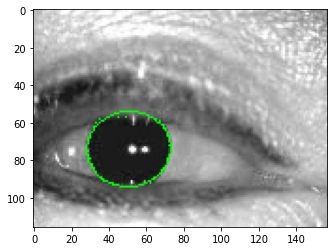

In [78]:
ellipse = cv2.fitEllipse(maxcnt)
im = cv2.ellipse(newImage1,ellipse,(0,255,0),1)
print(ellipse)
plt.imshow(im)

In [79]:
print(ellipse[0])

(50.52571487426758, 74.02251434326172)


In [80]:
def fit_rotated_ellipse_ransac(data,iter=30,sample_num=10,offset=80.0):

	count_max = 0
	effective_sample = None

	for i in range(iter):
		sample = np.random.choice(len(data), sample_num, replace=False)

		xs = data[sample][:,0].reshape(-1,1)
		ys = data[sample][:,1].reshape(-1,1)

		J = np.mat( np.hstack((xs*ys,ys**2,xs, ys, np.ones_like(xs,dtype=np.float))) )
		Y = np.mat(-1*xs**2)
		P= (J.T * J).I * J.T * Y

		# fitter a*x**2 + b*x*y + c*y**2 + d*x + e*y + f = 0
		a = 1.0; b= P[0,0]; c= P[1,0]; d = P[2,0]; e= P[3,0]; f=P[4,0];
		ellipse_model = lambda x,y : a*x**2 + b*x*y + c*y**2 + d*x + e*y + f

		# threshold 
		ran_sample = np.array([[x,y] for (x,y) in data if np.abs(ellipse_model(x,y)) < offset ])

		if(len(ran_sample) > count_max):
			count_max = len(ran_sample) 
			effective_sample = ran_sample

	return fit_rotated_ellipse(effective_sample)


def fit_rotated_ellipse(data):

	xs = data[:,0].reshape(-1,1) 
	ys = data[:,1].reshape(-1,1)

	J = np.mat( np.hstack((xs*ys,ys**2,xs, ys, np.ones_like(xs,dtype=np.float))) )
	Y = np.mat(-1*xs**2)
	P= (J.T * J).I * J.T * Y

	a = 1.0; b= P[0,0]; c= P[1,0]; d = P[2,0]; e= P[3,0]; f=P[4,0];
	theta = 0.5* np.arctan(b/(a-c))  
	
	cx = (2*c*d - b*e)/(b**2-4*a*c)
	cy = (2*a*e - b*d)/(b**2-4*a*c)

	cu = a*cx**2 + b*cx*cy + c*cy**2 -f
	w= np.sqrt(cu/(a*np.cos(theta)**2 + b* np.cos(theta)*np.sin(theta) + c*np.sin(theta)**2))
	h= np.sqrt(cu/(a*np.sin(theta)**2 - b* np.cos(theta)*np.sin(theta) + c*np.cos(theta)**2))

	ellipse_model = lambda x,y : a*x**2 + b*x*y + c*y**2 + d*x + e*y + f

	error_sum = np.sum([ellipse_model(x,y) for x,y in data])
	print('fitting error = %.3f' % (error_sum))

	return (cx,cy,w,h,theta)

fitting error = 0.000
50.53328717475715 72.81927633363263
fitting error = 0.000


Text(0.5, 1.0, 'Ellipse Fitting')

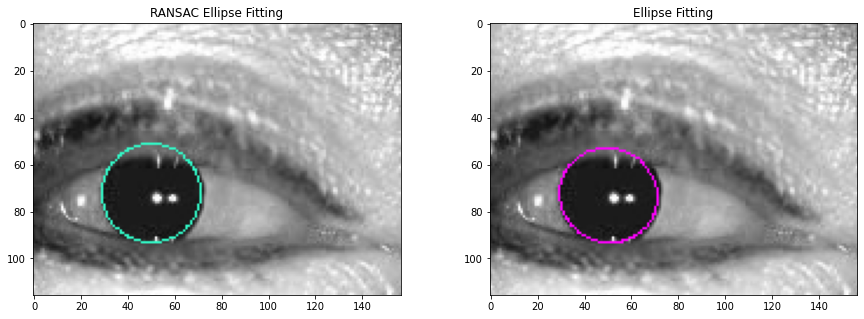

In [81]:
cx,cy,w,h,theta = fit_rotated_ellipse_ransac(maxcnt.reshape(-1,2))
print(cx,cy)
cx1,cy1,w1,h1,theta1 = fit_rotated_ellipse(maxcnt.reshape(-1,2))

fig = plt.figure(figsize=(15, 5))
rows = 1
columns = 2    

fig.add_subplot(rows, columns, 1)
  
# showing image
cv2.ellipse(newImage2,(int(cx),int(cy)),(int(w),int(h)),theta*180.0/np.pi,0.0,360.0,(50,250,200),1)
plt.imshow(newImage2)
plt.axis('on')
plt.title("RANSAC Ellipse Fitting")

fig.add_subplot(rows, columns, 2)
cv2.ellipse(newImage3,(int(cx1),int(cy1)),(int(w1),int(h1)),theta*180.0/np.pi,0.0,360.0,(255,0,255),1)
plt.imshow(newImage3)
plt.axis('on')
plt.title("Ellipse Fitting")